In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Load the data
data = pd.read_csv("dataset/recipes_82k.csv")
data.head()

,category,cooking_method,cuisine,image,ingredients,prep_time,recipe_name,serves,tags
0,NaN,['Set the racks in the middle and upper thirds...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['1 tablespoons extra virgin olive oil', '1 cu...",20 minutes,Mediterranean Sea Bass,4 servings,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,NaN,['Place the eggs in the air fryer basket and c...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['4 large eggs', 'Salt (black pepper, everythi...",15 minutes,Air Fryer Hard Boiled Eggs,4 eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,NaN,"['Air Fryer directions:', 'Preheat air fryer t...",['American'],https://www.skinnytaste.com/wp-content/uploads...,"['olive oil spray', '4 about 5 ounce each salm...",5 minutes,Air Fryer Basil-Parmesan Salmon,4 servings,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,NaN,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['American'],https://www.skinnytaste.com/wp-content/uploads...,['1/2 cup freshly grated Parmesan (not pre-gra...,15 minutes,Everything Parmesan Crisps,4 servings,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,NaN,['Cook potatoes in a large pot of salted water...,['American'],https://www.skinnytaste.com/wp-content/uploads...,['3 1/2 pounds new potatoes (about 10 peeled a...,10 minutes,Potato and Green Bean Salad,12 servings,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


In [12]:
data.drop(columns=['category', 'image', 'serves', 'cuisine', 'prep_time'], inplace=True)

In [13]:
data.dropna(subset=['tags'], inplace=True)
data.head()

,cooking_method,ingredients,recipe_name,tags
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...",Mediterranean Sea Bass,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...",Air Fryer Hard Boiled Eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...",Air Fryer Basil-Parmesan Salmon,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,Everything Parmesan Crisps,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,Potato and Green Bean Salad,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


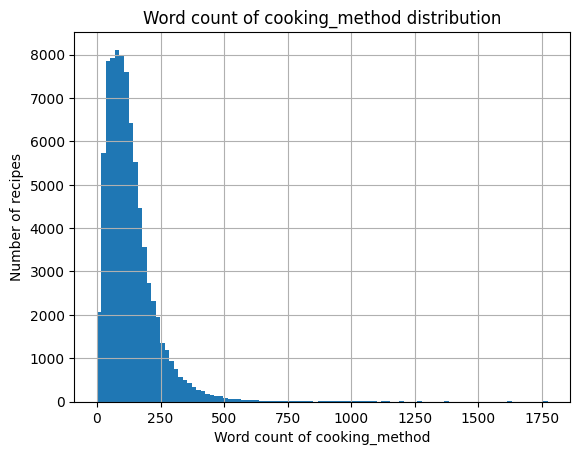

In [9]:
# number of words not letters
data['cooking_method'].str.split().apply(lambda x: len([word for word in x if word.isalpha()])).hist(bins=100)
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Word count of cooking_method distribution')
plt.show()


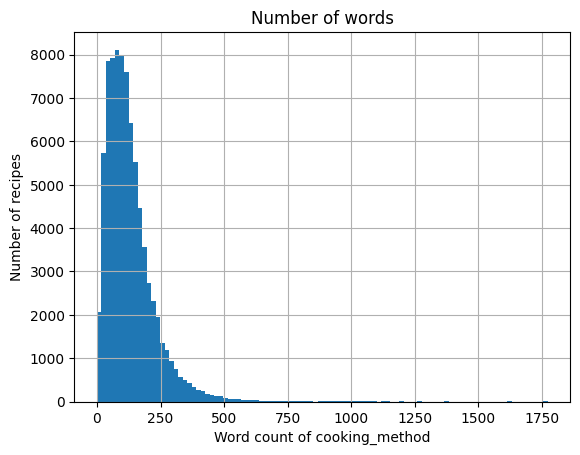

In [15]:
# count the number of words in the cooking_method column
data['cooking_method_word_count'] = data['cooking_method'].str.split().apply(lambda x: len([word for word in x if word.isalpha()]))
data['cooking_method_word_count'].describe()
#plot the distribution of the number of words in the cooking_method column
data['cooking_method_word_count'].hist(bins=100)
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Number of words')
plt.show()
